In [1]:
# import the required libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading Images from the Disk

In [2]:
# function that would read an image provided the image path, preprocess and return it back

def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (256, 256)) # resizing it (I just like it to be powers of 2)
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [3]:
X_train = [] # To store train images
y_train = [] # To store train labels

# labels -
# 0 - Covid
# 1 - Viral Pneumonia
# 2 - Normal

train_path = './dataset/train/' # path containing training image samples

In [4]:
for folder in os.scandir(train_path):
    for entry in os.scandir(train_path + folder.name):

        X_train.append(read_and_preprocess(train_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_train.append(0) # Covid
        elif folder.name[0]=='V':
            y_train.append(1) # Viral Pneumonia
        else:
            y_train.append(2) # Normal

In [5]:
X_train = np.array(X_train)
X_train.shape # We have 1955 training samples in total

(1955, 256, 256, 3)

In [6]:
y_train = np.array(y_train)
y_train.shape

(1955,)

## Visualizing the Dataset

<BarContainer object of 3 artists>

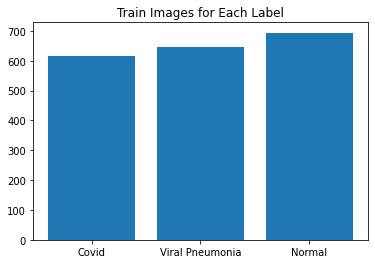

In [7]:
covid_count = len(y_train[y_train==0])
pneumonia_count = len(y_train[y_train==1])
normal_count = len(y_train[y_train==2])

plt.title("Train Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

# We have more samples of Normal and Viral Pneumonia than Covid

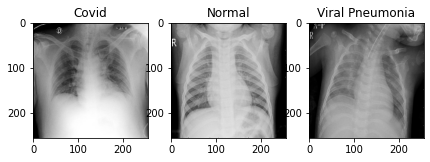

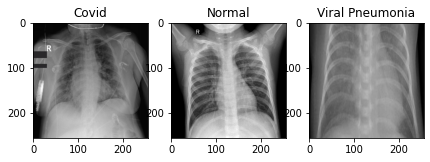

In [8]:
# Plotting 2 images per disease

import random

title = {0:"Covid", 1:"Viral Pneumonia", 2:"Normal"}

rows = 2
columns = 3

for i in range(2):
    
    fig = plt.figure(figsize=(7,7))
    
    fig.add_subplot(rows, columns, 1)
    pos = random.randint(0, covid_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 2)
    pos = random.randint(covid_count, covid_count+pneumonia_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])
    
    fig.add_subplot(rows, columns, 3)
    pos = random.randint(covid_count+pneumonia_count, covid_count+pneumonia_count+normal_count)
    plt.imshow(X_train[pos])
    plt.title(title[y_train[pos]])

## Image Augmentation
Augmentation is the process of creating new training samples by altering the available data. <br>
It not only increases the number of samples for training the model but also prevents the model from overfitting the training data since it makes relevant feautes in the image location invariant. <br>
Although there are various ways of doing so like random zoom, increasing/decreasing brightness, rotating the images, most of it does not make sense for Health related data as the real world data is almost always of high quality. <br>
So we only applied one type of Image Augmentation in this Model : <b> Horizontal Flip </b>. <br>
Now, even if we try to classify horizontaly flipped images, we can expect to get correct predictions.

Text(0.5, 1.0, 'Original Image')

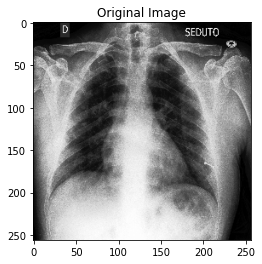

In [9]:
plt.imshow(X_train[0])
plt.title("Original Image")

Text(0.5, 1.0, 'Horizontaly Flipped Image')

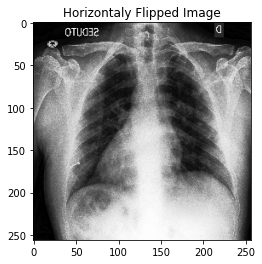

In [10]:
X_new = np.fliplr(X_train[0])
plt.imshow(X_new)
plt.title("Horizontaly Flipped Image")

In [11]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    X_new = np.fliplr(X_train[i])
    X_aug.append(X_new)
    y_aug.append(y_train[i])

In [12]:
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [13]:
X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
X_train.shape

(3910, 256, 256, 3)

In [14]:
y_train = np.append(y_train, y_aug, axis=0)
y_train.shape
# Now we have 3910 samples in total

(3910,)

## Spliting the data for Training and Validation

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# We have splitted our data in a way that - 
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, shuffle=True, stratify=y_train, random_state=123)

In [17]:
# we will use 3323 images for training the model
y_train.shape

(3323,)

In [18]:
# we will use 587 images for validating the model's performance
y_val.shape

(587,)

## Designing and Training the Model

In [19]:
model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((4,4)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization
    
    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        65600     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       2

In [21]:
# Slowing down the learning rate
opt = optimizers.Adam(learning_rate=0.0001)

In [22]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

In [23]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="covid_classifier_weights.h5", verbose=1, save_best_only=True)

In [24]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), batch_size=32, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
104/104 [==============================] - ETA: 0s - loss: 1.0979 - accuracy: 0.3578
Epoch 00001: val_loss improved from inf to 1.09129, saving model to covid_classifier_weights.h5
104/104 [==============================] - 10s 96ms/step - loss: 1.0979 - accuracy: 0.3578 - val_loss: 1.0913 - val_accuracy: 0.5911
Epoch 2/100
104/104 [==============================] - ETA: 0s - loss: 1.0391 - accuracy: 0.4535
Epoch 00002: val_loss improved from 1.09129 to 0.75913, saving model to covid_classifier_weights.h5
104/104 [==============================] - 9s 84ms/step - loss: 1.0391 - accuracy: 0.4535 - val_loss: 0.7591 - val_accuracy: 0.6167
Epoch 3/100
104/104 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.7526
Epoch 00003: val_loss improved from 0.75913 to 0.53943, saving model to covid_classifier_weights.h5
104/104 [==============================] - 9s 83ms/step - loss: 0.5799 - accuracy: 0.7526 - val_loss: 0.5394 - val_accuracy: 0.7700
Epoch 4/100
104/

103/104 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.9639
Epoch 00027: val_loss did not improve from 0.11622
104/104 [==============================] - 6s 58ms/step - loss: 0.0980 - accuracy: 0.9642 - val_loss: 0.1194 - val_accuracy: 0.9489
Epoch 28/100
103/104 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9639
Epoch 00028: val_loss did not improve from 0.11622
104/104 [==============================] - 6s 58ms/step - loss: 0.1043 - accuracy: 0.9639 - val_loss: 0.1240 - val_accuracy: 0.9489
Epoch 29/100
103/104 [============================>.] - ETA: 0s - loss: 0.0968 - accuracy: 0.9663
Epoch 00029: val_loss improved from 0.11622 to 0.11331, saving model to covid_classifier_weights.h5
104/104 [==============================] - 6s 59ms/step - loss: 0.0968 - accuracy: 0.9663 - val_loss: 0.1133 - val_accuracy: 0.9608
Epoch 30/100
103/104 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9672
Epoch 00030: val_loss d

103/104 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9876
Epoch 00055: val_loss did not improve from 0.08688
104/104 [==============================] - 6s 58ms/step - loss: 0.0377 - accuracy: 0.9874 - val_loss: 0.1026 - val_accuracy: 0.9727
Epoch 56/100
103/104 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy: 0.9857
Epoch 00056: val_loss did not improve from 0.08688
104/104 [==============================] - 6s 58ms/step - loss: 0.0384 - accuracy: 0.9856 - val_loss: 0.0990 - val_accuracy: 0.9710
Epoch 57/100
104/104 [==============================] - ETA: 0s - loss: 0.0459 - accuracy: 0.9847
Epoch 00057: val_loss did not improve from 0.08688
104/104 [==============================] - 6s 58ms/step - loss: 0.0459 - accuracy: 0.9847 - val_loss: 0.0982 - val_accuracy: 0.9727
Epoch 58/100
103/104 [============================>.] - ETA: 0s - loss: 0.0439 - accuracy: 0.9851
Epoch 00058: val_loss improved from 0.08688 to 0.08134, saving model to 

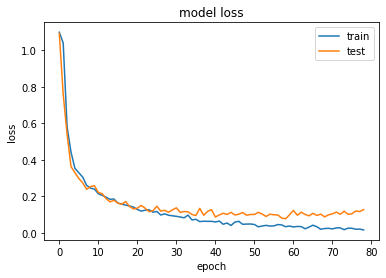

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

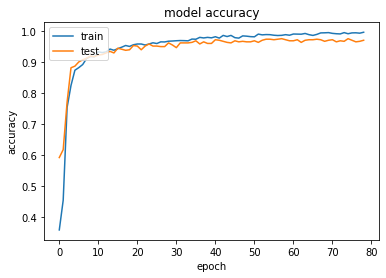

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("covid_classifier_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [28]:
# Load pretrained model (best saved one)
with open('covid_classifier_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('covid_classifier_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

### Loading the Test Images

In [29]:
X_test = [] # To store test images
y_test = [] # To store test labels

test_path = './dataset/test/'

for folder in os.scandir(test_path):
    for entry in os.scandir(test_path + folder.name):

        X_test.append(read_and_preprocess(test_path + folder.name + '/' + entry.name))
        
        if folder.name[0]=='C':
            y_test.append(0)
        elif folder.name[0]=='V':
            y_test.append(1)
        else:
            y_test.append(2)
            
X_test = np.array(X_test)
y_test = np.array(y_test)

In [30]:
X_test.shape # We have 185 images for testing

(185, 256, 256, 3)

<BarContainer object of 3 artists>

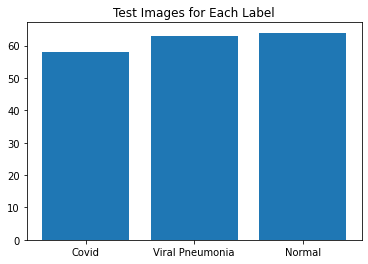

In [31]:
covid_count = len(y_test[y_test==0])
pneumonia_count = len(y_test[y_test==1])
normal_count = len(y_test[y_test==2])

plt.title("Test Images for Each Label")
plt.bar(["Covid", "Viral Pneumonia", "Normal"],[covid_count, pneumonia_count, normal_count])

In [32]:
# making predictions
predictions = model.predict(X_test)

In [33]:
predictions.shape

(185, 3)

In [34]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [35]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.9945945945945946

<AxesSubplot:>

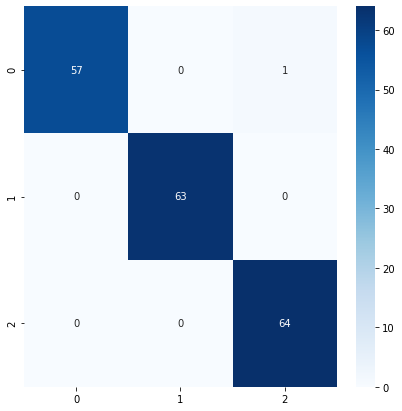

In [36]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

# The model misclassified one Covid case as Normal

In [37]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       1.00      1.00      1.00        63
           2       0.98      1.00      0.99        64

    accuracy                           0.99       185
   macro avg       0.99      0.99      0.99       185
weighted avg       0.99      0.99      0.99       185

